# Планирование траектории с помощью полиномов пятого порядка
## Положение motion_planner в системе управления беспилотным автомобилем
Motion planner занимается планированием локальной траеткории, чтобы она была достижима для автомобиля (не нарушала
его кинематические и динамические ограничения) и не сталкивалась с препятствиями. Motion planner получает цель (положение и скорость) от планнара более высокого порядка. Помиом этого, из-за особенностей текущего подхода к реализации планнера, ему потребуется некий идеальный опорный путь, `reference_path`, от которого он будет отталкиваться. Например, это может быть просто центр полосы, по которой едет автомобиль, а планер уже сформирует `local_path`, который будет учитывать скорость, избегать препятствия и т.п.
## Идея решения
Идея решения ~~начисто сплагиачена~~ основана на статье [Optimal Trajectory Generation for Dynamic Street Scenarios in a Frenet Frame](https://www.researchgate.net/publication/224156269_Optimal_Trajectory_Generation_for_Dynamic_Street_Scenarios_in_a_Frenet_Frame)

### Frenet frame
Мы зададим траекторию движения автомобиля из одной точки в другую путем интерполяции кривой. Важно заметить, что траектория - не просто линия на 2D плоскости, а изменение положения, скорости и ускорения автомобиля от времени.

Для упрощения задачи мы не будем осуществлять планирование в глобальной декартовой системе координат, а выберем
движующую систему координат, связанную с `reference_path` или `center line`. По-английски это называется Frenét Frame method, по-русски не знаю. На рисунке изображено положение автомобиля относительно системы координат:

![](img/junior_frenet_frame.png)

$
\begin{align*}
    \text{где } & \vec{r}(s)           &-&  \text{ центр подвижной С.К.}\\
                & \vec{n}_r, \vec{t}_r &-& \text{ нормальный и тангенцальный векторы подвижной С.К.,}\\
                & s(t)                 &-& \text{ покрытая длина дури за время}\\
                & \vec{x}(s,d)         &-& \text{ координата автомобиля в глобальной С.К.,}\\
                & \vec{x}_x, \vec{t}_x &-& \text{ нормальный и тангенцальный векторы С.К. автомобиля,}\\
                & d(t)                 &-& \text{ расстояние автомобиля от центральной линии.}
\end{align*}
$

### Про полиномы
Будем рассматривать отдельно продольное движение вдоль `reference_path` $s(t)$ и поперечное движение $d(s)$, а затем объединим их.  Мы хотим, чтобы $jerk = \dot{d} = \dddot{d}$ (рывок) был минимален. Хотим, чтобы и та, и та траектория имели минимальный $jerk$, т.е. минимизировали следующую функцию стоимости (приведено для поперечного, для продольного аналоигично:
$$
J = \int_{t_0}^{t_1}{\dddot{d}d\tau}
$$


Из какого-то хардкорного матана известно, что оптимальным решением в данном случае будут полиномы пятого порядка:
$$
\begin{align}
y(x)        &= a_1 x^5 + a_2 x^4 + a_3 x^3 + a_4 x^2 + a_5 x + a_6 \\
\dot{y}(x)  &= 5a_1 x^4 + 4a_2 x^3 + 3a_3 x^2 + 2a_4 x^2 + a_5 \\
\ddot{y}(x) &= 20a_1 x^3 + 12a_2 x^2 + 6a_3 x + 2a_4 \\
\end{align}
$$

$
\begin{align*}
    \text{где } y   &- \text{зависимая переменная, s(t) или d(s),}\\
                a_i &- \text{коэффициенты.}
\end{align*}
$

Профит тут еще в том, что такие полиномы гладко между собой стыкуются. Если мы расчитали участок траектории, проехали по нему, взяли новые текущие положение, скорость, ускорение, и использовали их для построения нового полинома, то положение и первая производная (скорость) стыкуются гладко.

Тогда подставим граничные условия $y(0)$, $\dot{y}(0)$, $\ddot{y}(0)$, $y(T)$, $\dot{y}(T)$, $\ddot{y}(T)$ получим систему линейых уравнений относительно $a_i$ и найдем коэффициенты. В качестве начальных условий берется текущее состояние автомобиля, полученное с датчиков, а в качестве конечного - желаемое состояние, полученное от планнера более высокого порядка.

### Поперечное движение
Текущее отклонение автомобиля от `reference_path` $d_0$, текущие боковая скорость и ускорение $\dot{d_0}$ и $\ddot{d_0}$ соответственно. Хотим, чтобы автомобиль за время T перешел состояние, где отклонение от `reference_path` будет $d_1$, боковые скорость и ускорение равны нулю.

$$
D_0 = [d_0, \dot{d_0}, \dot{d_0}] \\
D_1 = [d_1, 0, 0, T]
$$

Функция стоимости%
$$
C_{lat} = k_j \int_{t_0}^{t_1}{\dddot{d}d\tau} + k_t T = k_p d_{err}^2
$$

$
\begin{align*}
    \text{где } & k_j, k_t, k_p  &-&  \text{ коэффициенты,}\\
                & T              &-& \text{ время выполнения маневра,}\\
                & d_{err}        &-& \text{ финальное отклонение от желаемого поперечного положения. }
\end{align*}
$

Суть в том, чтоы мы хотим, чтобы дергания (jerk) во время маневра было как можно меньше (планывй маневр), но и он был не очень долгим, ну и таки привел нас в требуемое положение.

Аналогично с продольным движением, но там хитрее, потому что может быть такое, когда мы просто едем по пустой дороге, надо задать целевую скорость, но целевого положения нет. Наверное, согласно статье. Я еще не продумал этот момент.

Задача найти коэффициенты, которые дадут траекторию,  которая будет оптимизировать заданную функцию стоимости, да еще не будет натыкаться на препятствия, удовлетоврять кинематическим и динамическим ограничениям, матанистически невозможно (ну либо очент трудно). Поэтому мы просто зададим множество конечных точек, немного отличающихся друг от друга, получим кучу траекторий из одной точки и выберем из них лучшую.

Варьируем конечное положение и время выполнения маневра:
$$
D_1 = [d_1, \dot{d_1}, \ddot{d_1}, T]_{ij} = [d_{1i}, \dot{d_1}, \ddot{d_1}, T_j]
$$

### Продольное движение
Аналогично, но есть свои хитрости. Есть различные режимы движения, такие как
- движение по пустой полосе: есть целевая скорость, но нет целевого положения
- следование за машиной, остановкаи итп: можно описать как целевое положение + целевая скорость. В статье описыввается сложновато, но, думаю, это можно свести к этим параметрам, выбирать которые будет вышележащий планировщик. 

In [1]:
import numpy as np
import numpy.polynomial.polynomial as npoly
import matplotlib.pyplot as plt
from car_core.motion_planner.frenet import FrenetFrame
import car_core.motion_planner.quintic as quintic
from car_core.motion_planner.trajectory import Trajectory1D
import math

In [2]:
# Вспомогательная функция, позволяет сделать по одной записи в легенде графика
# для нескольких графиков с одним legend
def legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    u_labels = []
    u_handles = []
    for handle, label in zip(handles, labels):
            if label not in u_labels:
                u_labels.append(label)
                u_handles.append(handle)    
    ax.legend(u_handles, u_labels)

## 1. Пример расчета движения
### 1.1. Базовый расчет
Это пример расчета продольного движения. Автомобиль тормозит с некой начальной скорости до полной остановки. Для определения коэффициентов полинома, нам нужно также время совершения маневра $T$, которое нельзя выбрать произвольным, потому что у нас определны начальная скорость и тормозной путь. В случае неправильного выбора T можно получить решения, в которых автомобиль проезжает дальше, чем надо, а потом движется назад; либо вначале резко ускоряется, чтобы затормозить. 

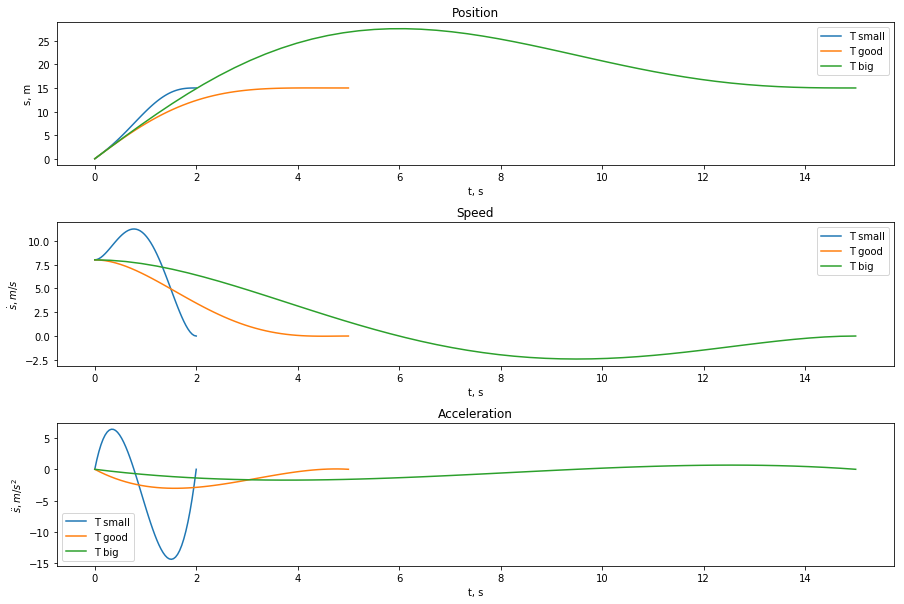

In [3]:
_, ax = plt.subplots(3, 1,  figsize=(15,10))
plt.subplots_adjust(hspace=0.4)

# Начальное и конечное сотояние
S0 = (0.0, 8.0, 0.0)
S1 = (15.0, 0.0, 0.0)

# Расчитывает и строит полиномы для заданного времени маневра t
def calc_plot(t, label):
    t_values = np.linspace(0, t, 50)
    coefs = quintic.calc_coefs(S0, S1, t)
    s, ds, dds =  quintic.interpolate(coefs, t_values)
    ax[0].plot(t_values, s, label=label)
    ax[1].plot(t_values, ds, label=label)
    ax[2].plot(t_values, dds, label=label)
    
calc_plot(2, 'T small')
calc_plot(5, 'T good')
calc_plot(15, 'T big')

ax[0].set_title('Position')
ax[0].set_xlabel('t, s')
ax[0].set_ylabel('s, m')
ax[1].set_title('Speed')
ax[1].set_xlabel('t, s')
ax[1].set_ylabel(r'$\dot{s}, m/s$')
ax[2].set_title('Acceleration')
ax[2].set_xlabel('t, s')
ax[2].set_ylabel(r'$\ddot{s}, m/s^2$')
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

### 1.2. Оценка времени маневра
Чтобы этого избежать, в начале как-нибудь оцним подходящее $T_0$ исходя из начального и конечного состояния, а потом будем варьировать $T$: $T \in [T_0 - \Delta T, T_0 + \Delta T]$.

В качестве такой оценки выбрано равноускоренное движение:
$$
\begin{cases}
v_1 = v_0 + at \\
s_1 = s_0 + v_0t + \frac{at^2}{2}
\end{cases}
$$

Решая данную систему получим $t$ и $a$ (нам не нужно).

Это не дает идеального решения для всех случаев, но, в целом, неплохо, и его можно взять за начальную оценку $T$. Потом все равно будет сформирован набор отличающихся в обе стороны значений и выбрана лучшая возможная траектория.

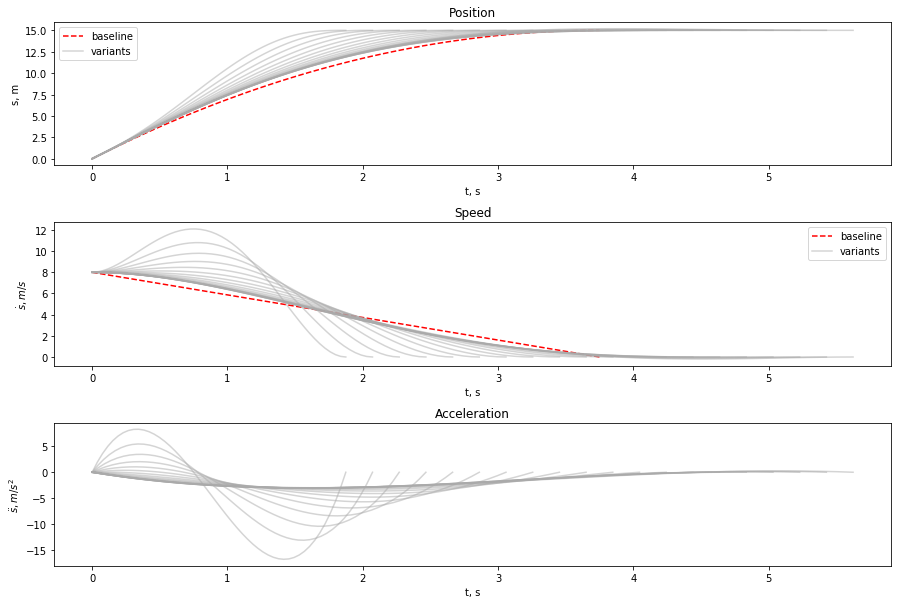

In [4]:
# Расчитывает коэффициенты полинома для случая 
# равноускоренного движения, который взят за основу
def calc_baseline_coefs(s0, s1):
    # v1 = v0 + a*t
    # s1 = s0 + v0*t + a*t^2/2
    t = (2*(s1[0] - s0[0]))/(s0[1] + s1[1])
    a = (s1[1] - s0[1])/t
    return t, np.array([0, 0, 0, a/2, s0[1], 0])


                    
_, ax = plt.subplots(3, 1,  figsize=(15,10))
plt.subplots_adjust(hspace=0.4)

# Начальное и конечное сотояние
S0 = (0.0, 8.0, 0.0)
S1 = (15.0, 0.0, 0.0)
                    
# Расчет baseline
base_t, baseline_coefs = calc_baseline_coefs(S0, S1)
t_values = np.linspace(0, base_t, 50)
b_s, b_ds, b_dds = quintic.interpolate(baseline_coefs, t_values)
ax[0].plot(t_values, b_s, '--r', label='baseline')
ax[1].plot(t_values, b_ds, '--r', label='baseline')

# Расчет вариантов
ts = np.linspace(0.5*base_t, 1.5*base_t, 20)
for t in ts:
    coefs = quintic.calc_coefs(S0, S1, t)
    t_values = np.linspace(0, t, 50)
    s, ds, dds =  quintic.interpolate(coefs, t_values)
    color = '#AAAAAA'
    alpha = 0.5
    ax[0].plot(t_values, s, color=color, alpha=alpha, label='variants')
    ax[1].plot(t_values, ds, color=color, alpha=alpha, label='variants')
    ax[2].plot(t_values, dds, color=color, alpha=alpha)

ax[0].set_title('Position')
ax[0].set_xlabel('t, s')
ax[0].set_ylabel('s, m')
ax[1].set_title('Speed')
ax[1].set_xlabel('t, s')
ax[1].set_ylabel(r'$\dot{s}, m/s$')
ax[2].set_title('Acceleration')
ax[2].set_xlabel('t, s')
ax[2].set_ylabel(r'$\ddot{s}, m/s^2$')
legend(ax[0])
legend(ax[1])

## 2. Расчет траекторий атомобиля
### 2.1. Расчет набора траекторий

(0.0, 8.0, 0.0)
(0.0, 0.0, 0.0)
(30.0, 0.0, 0.0)
(0.0, 0.0, 0.0)


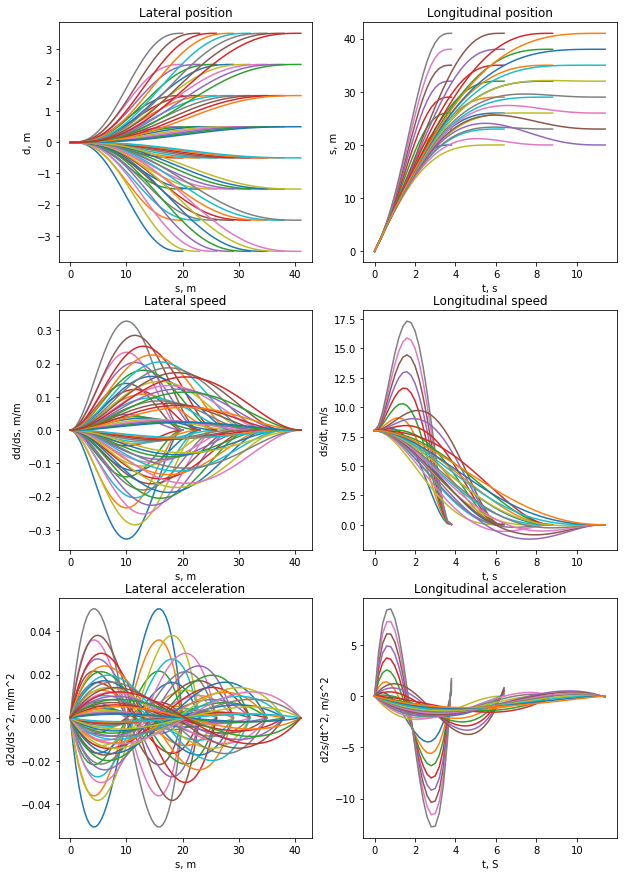

In [5]:

ROAD_WIDTH = 3.5*2          # Ширина дороги - допустимой для езды области
D_MIN   = -ROAD_WIDTH/2     # Миимальное значение поперечного положения
D_MAX   =  ROAD_WIDTH/2     # Максимальное значение поперечного положения
D_STEP  =  1                # Шаг переребора поперечных положений

S_DEV   =  10               # Максимальное отклонение продольного положения вперед/назад
                            # от заданного. si = [s_target - S_DEV, s_target + S_DEV]
S_STEP  =  3                # Шаг перебора продольных положений

T_DEV   =  0.5              # Максимальное отклонение времени от примерной оценки
                            # ti = [(1-T_DEV)*t_estimate, (1+T_DEV)*t_estimate]
T_CNT   =  4                # Количество переборов времени

S_CALC_STEP = 0.5           # Шаг интерполяции по продольному расстоянию (длине дуги)
T_CALC_STEP = 0.2           # Шаг интерполяции по времени

ROAD_LENGTH   = 50
N_ROAD_POINTS = 50

#----------------------------------------------------

def arange(min, max, step):
    return np.arange(min, max+step, step)

# Return longtitudinal and lateral states in frenet frame for 
# given state in cartesian frame
def get_state_in_frenet_frame(frame, pos, vel, acc):
    pos_f = frenet_frame.point_to(pos)
    vel_f = frenet_frame.vector_to(vel)
    acc_f = frenet_frame.vector_to(acc)
    s = (pos_f[0], vel_f[0], acc_f[0])
    d = (pos_f[1], vel_f[1], acc_f[1])
    return s, d
    
#----------------------------------------------------

# Пример входных значений: траектоия, начальное и конечное состояние
np_path = np.stack((np.linspace(0,ROAD_LENGTH,N_ROAD_POINTS), np.zeros(N_ROAD_POINTS)), axis=1)
pos0 = [0,0]
vel0 = [8,0]
pos1 = [30,0]
vel1 = [0,0]

# Calc initial position and velocity in Frenet frame
frenet_frame = FrenetFrame(0, np_path[0], np_path[1])
S0, D0 = get_state_in_frenet_frame(frenet_frame, pos0, vel0, [0,0])  # Initial lon & lat states
S1, D1 = get_state_in_frenet_frame(frenet_frame, pos1, vel1, [0,0])  # Target lon & lat states
s0, ds0, dds0 = S0 # s, ds/dt, d2s/dt^2
d0, dd0, ddd0 = D0
s1, ds1, dds1 = S1
d1, dd1, ddd1 = D1

print(s0, ds0, dds0)
print(d0, dd0, ddd0)
print(s1, ds1, dds1)
print(d1, dd1, ddd1)

# Estimate time
t_estimate, _ = calc_baseline_coefs((s0, ds0, dds0), (s1, ds1, dds1))

s_min = s1 - S_DEV
s_max = s1 + S_DEV
t_min = (1-T_DEV)*t_estimate
t_max = (1+T_DEV)*t_estimate

s_list = arange(s_min, s_max, S_STEP)
       
# Calculate longtitudinal trajectories
lon_trajectories = []
for ti in np.linspace(t_min, t_max, T_CNT):
    t_values = arange(0, ti, T_CALC_STEP)
    for si in s_list:
        lon_coefs = quintic.calc_coefs((s0, ds0, dds0), (si, 0, 0), ti)
        lon_trajectory = Trajectory1D(t_values, *quintic.interpolate(lon_coefs, t_values))    
        lon_trajectories.append(lon_trajectory)


# Calculate lateral trajetrories
lat_trajectories = []
for si in s_list:
    s_values = arange(0, si, S_CALC_STEP)
    for di in arange(D_MIN, D_MAX, D_STEP):
        lat_coefs = quintic.calc_coefs((d0, dd0, ddd1), (di, 0, 0), si)
        lat_trajectory = Trajectory1D(s_values, *quintic.interpolate(lat_coefs, s_values))
        lat_trajectories.append(lat_trajectory)
        
_, ax = plt.subplots(3, 2,  figsize=(10,15))

for trajectory in lat_trajectories:
    ax[0,0].plot(trajectory.x, trajectory.y) 
    ax[1,0].plot(trajectory.x, trajectory.dy) 
    ax[2,0].plot(trajectory.x, trajectory.ddy) 

ax[0,0].set_title('Lateral position')
ax[0,0].set_ylabel('d, m')
ax[0,0].set_xlabel('s, m')

ax[1,0].set_title('Lateral speed')
ax[1,0].set_ylabel('dd/ds, m/m')
ax[1,0].set_xlabel('s, m')

ax[2,0].set_title('Lateral acceleration')
ax[2,0].set_ylabel('d2d/ds^2, m/m^2')
ax[2,0].set_xlabel('s, m')    
    
for trajectory in lon_trajectories:
    ax[0,1].plot(trajectory.x, trajectory.y) 
    ax[1,1].plot(trajectory.x, trajectory.dy) 
    ax[2,1].plot(trajectory.x, trajectory.ddy) 
    
ax[0,1].set_title('Longitudinal position')
ax[0,1].set_ylabel('s, m')
ax[0,1].set_xlabel('t, s')

ax[1,1].set_title('Longitudinal speed')
ax[1,1].set_ylabel('ds/dt, m/s')
ax[1,1].set_xlabel('t, s')

ax[2,1].set_title('Longitudinal acceleration')
ax[2,1].set_ylabel('d2s/dt^2, m/s^2')
ax[2,1].set_xlabel('t, S')
    
#ax1.plot(np_path[:,0], np_path[:,1], marker='o', markersize=3)   

plt.show()

### 2.2. Выбор допустимых траекторий

Теперь среди всех сгенерированных траекторий выбираем допустимые на основе
 - максимальной продольной скорости
 - максимального продольного ускорения
 - минимального радиуса разворота
 - ??? попереченого ускорения ???
 - ???
 
### 2.3. Объединение поперечных и продольных траекторий
Затем сформированные поперечные и продольные траеткории комбинируются, чтобы сформировать полные траеткории в Frenet Frame (t, s, d). 
 
### 2.4. Проверка на пересечения с препятствиями
Полученная траектория переводится из Frenet Frame обратно в глобальную декартову систему координат и проверяется на пересечение с препятствиями. Траектории, которые пересекаются с препятствиями отбрасываются.
 
### 2.5. Расчет функции стоимости и выбор оптимальной траектории
Для валидных траекторий расчитывается их функция стоимости. На самом деле функция стоимости расчитывается отдельтно для поперечного и продольного движения, а затем суммируется с весовыми коэффициентами:
$$
C_{tot} = k_{lat}C_{lat} + k_{lon}C_{lon}
$$
Поэтому они могут быть расчитаны ранее, чтобы не расчитывать несколько раз для одной и той же траектории.

На основе функции стоимости выбирается оптимальная траектория.

## Имплементация
В реальной имплементации оптимальнее сделать несколько иначе. Вместо того, чтобы так все красиво разбивать на шаги, проще и эффективнее считать все сразу, сразу выкидывать неподходящие траектории и т.п. Порядок разнызх проверок (например, что проверять вначале - стоимость или пересечения) может зависить от того, что всетрчается чаще и что считать тяжелее.